In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import spectrogram
from cmath import cos, sin, pi

In [156]:
# Load the raw EEG data
eeg_data = pd.read_csv("data/Liuyin-5April/Morning/wet_17hz_0504_clean_ExG.csv")
chan_name = ['PO3','POz','PO4', 'PO7', 'O1', 'Oz', 'O2', 'PO8']
# Set the sampling rate and the filter cutoff frequencies
fs = 250
low_cutoff = 1
high_cutoff = 40
target_frequncy = 17
target_frequencies = [15, 16, 17, 18 ,19] # <-This is ilustrative.Best to use harmonics of the target frequency

#Create two dataframes from eeg_data the first is the first column which is the timestamp and the second is the remaiing columns which are the EEG data
eeg_data_timestamp = eeg_data.iloc[:,0]
eeg_data_eeg = eeg_data.iloc[:,1:]

# Create an array of the EEG data
eeg_array = eeg_data_eeg.to_numpy() # 40672 rows x 8 columns (channels)
eeg_array = eeg_array.T # 8 rows (channels) x 40672 columns (samples)

# Apply a bandpass filter to the EEG data 
b, a = signal.butter(4, [low_cutoff/(fs/2), high_cutoff/(fs/2)], btype='bandpass')
eeg_filtered = signal.filtfilt(b, a, eeg_array, axis=1)

# Get information about the EEG data
# Get length of the EEG data
n = len(eeg_filtered[0])
# Get number of channels
m = len(eeg_filtered)
# Get the time vector
t = np.linspace(0, n/fs, n)

#Plot PSD of the EEG data before and after filtering from 0-40 Hz
f, Pxx_den = signal.welch(eeg_array, fs, nperseg=1024) # f length is 513, Pxx_den is 8 rows (channels) x 513 columns (frequencies)
f, Pxx_den_filtered = signal.welch(eeg_filtered, fs, nperseg=1024) # f length is 513, Pxx_ded_filtered is 8 rows (channels) x 513 columns (frequencies)
# Keep only the frequencies between 0 and 40 Hz
Pxx_den = Pxx_den[:,0:201]
Pxx_den_filtered = Pxx_den_filtered[:,0:201]

left_channels = ['PO3', 'PO7', 'O1']
center_channels = ['POz', 'Oz']
right_channels = ['PO4', 'PO8', 'O2']

# Convert the channels to the corresponding index from chan_name
left_channels_index = [chan_name.index(i) for i in left_channels]
center_channels_index = [chan_name.index(i) for i in center_channels]
right_channels_index = [chan_name.index(i) for i in right_channels]

# Find the average PSD for the zone from the channels that are in each zone 
left_PSD = np.mean(Pxx_den[left_channels_index,:], axis=0)
center_PSD = np.mean(Pxx_den[center_channels_index,:], axis=0)
right_PSD = np.mean(Pxx_den[right_channels_index,:], axis=0)
zones = [left_PSD, center_PSD, right_PSD]
zone_names = ['Left', 'Center', 'Right']

# Print the shape of the PSD for each zone
print('Shape of PSD for each zone')
for i in range(len(zone_names)):
    print(zone_names[i], zones[i].shape)


# Calculate the total power in each zone and the total power in target_frequencies
total_power = []
target_power = []
for i in range(len(zone_names)):
    total_power.append(np.sum(zones[i]))
    target_power.append(np.sum(zones[i][target_frequencies[0]:target_frequencies[-1]])) # 15-19 Hz
    

# Calculate the SNR of the target_frequencies from the average of each zone
SNR = []
for i in range(len(zone_names)):
    SNR.append(target_power[i]/(total_power[i]-target_power[i]))

# Calulate the SNR of the target_frequencies from the average of all the channels and all the frequencies
total_power_all = np.sum(Pxx_den)
target_power_all = np.sum(Pxx_den[target_frequencies[0]:target_frequencies[-1]])
SNR_all = target_power_all/(total_power_all-target_power_all)

print('SNR_all', SNR_all)


# Print the SNR for each zone
print('SNR for each zone')
for i in range(len(zone_names)):
    print(zone_names[i], SNR[i])  
    
  

Shape of PSD for each zone
Left (201,)
Center (201,)
Right (201,)
SNR_all 0.0
SNR for each zone
Left 0.016917894912039676
Center 0.019411461350376514
Right 0.02180296425187007


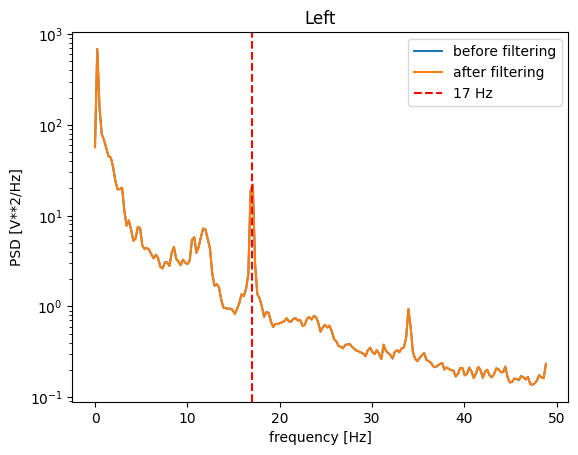

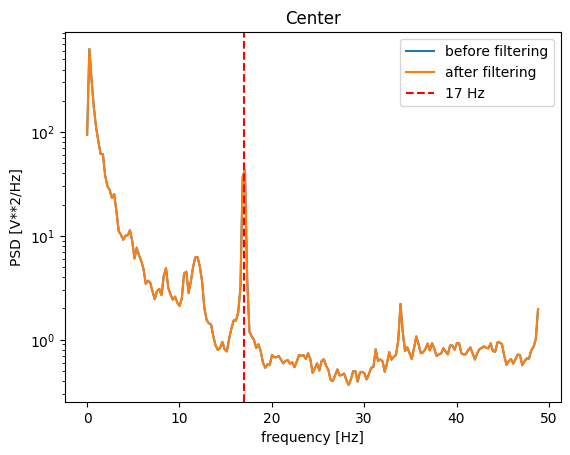

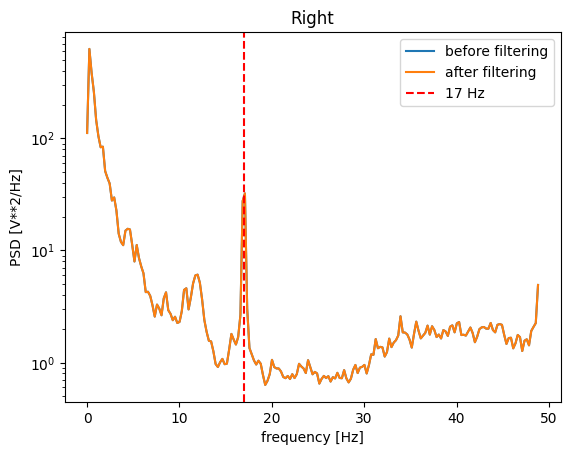

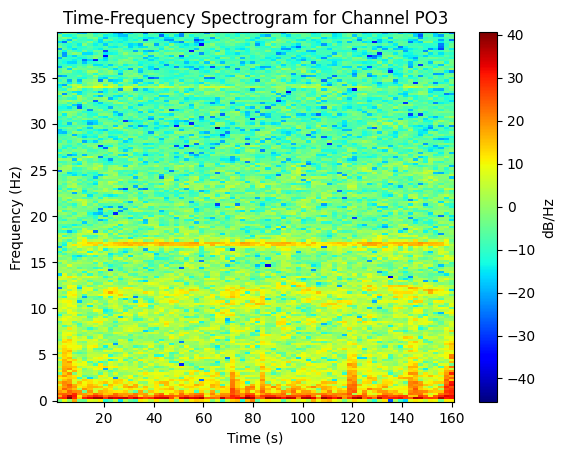

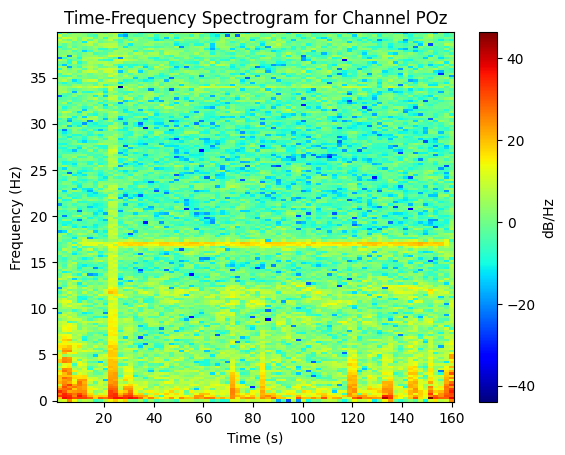

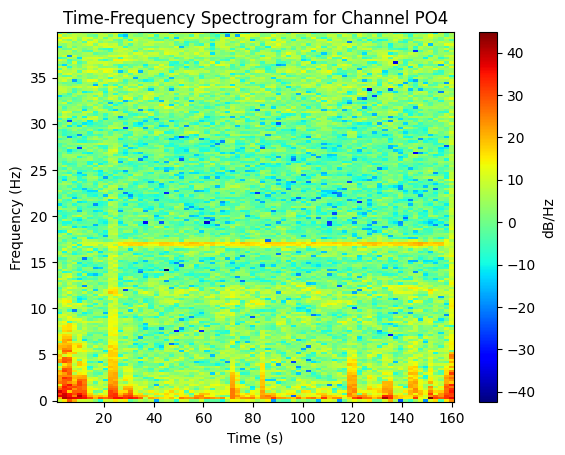

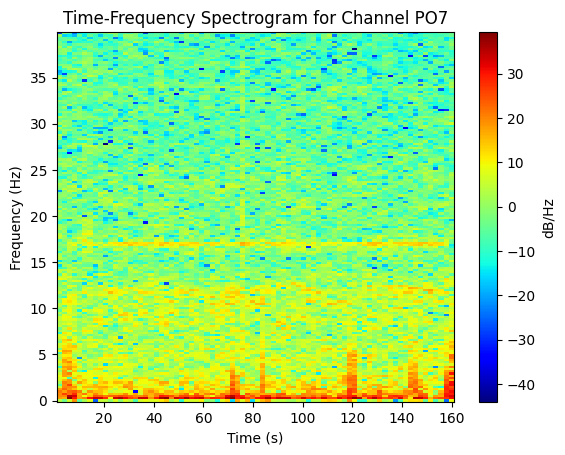

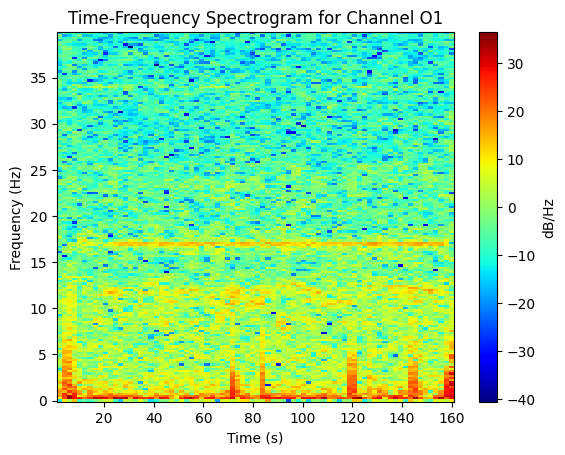

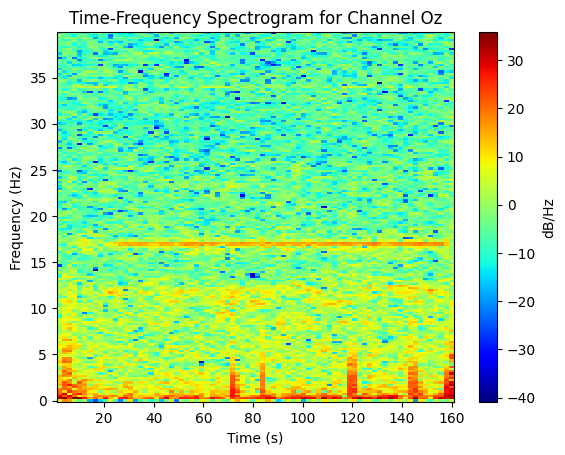

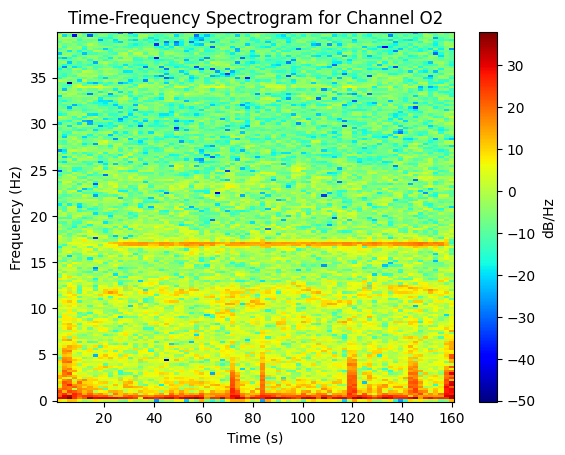

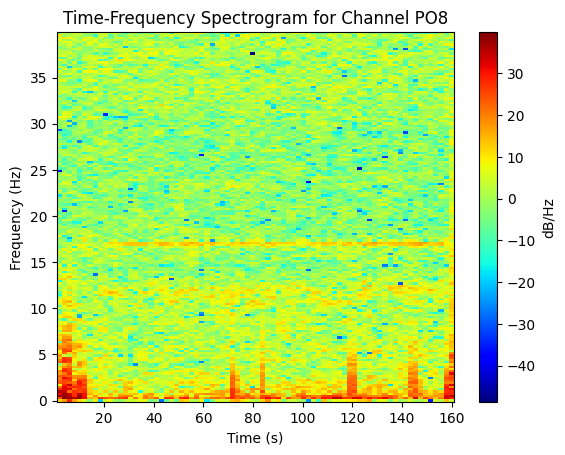

In [157]:
# Visualise the data
# Plot the PSD before and after filtering for zones
for i in range(3):
    plt.figure()
    plt.semilogy(f[0:201], zones[i], label='before filtering')
    plt.semilogy(f[0:201], zones[i], label='after filtering')
    plt.xlabel('frequency [Hz]')
    # Using channel names as labels for the plots
    plt.title(zone_names[i])
    plt.ylabel('PSD [V**2/Hz]')
    # Add a white line at 17 Hz
    plt.axvline(x=17, color='red', linestyle='--', label='17 Hz')
    plt.legend()
    plt.show()

# Define parameters for spectrogram
fs = 250  # Sampling frequency
nperseg = 1024  # Number of samples per segment
noverlap = 512  # Number of samples overlapping between segments
f_range = [0, 40]  # Frequency range of interest in Hz


# Loop through each channel
for channel_index in range(len(eeg_array)):
    # Compute the spectrogram for the current channel
    freqs, t, Sxx = spectrogram(eeg_array[channel_index], fs, nperseg=nperseg, noverlap=noverlap)

    # Select the frequency range of interest
    freq_idx = (freqs >= f_range[0]) & (freqs <= f_range[1])
    freqs = freqs[freq_idx]
    Sxx = Sxx[freq_idx, :]

    # Plot the spectrogram and some visible lines at target_freqs in Hz
    plt.pcolormesh(t, freqs, 10 * np.log10(Sxx), cmap='jet')
    plt.colorbar(label='dB/Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Time-Frequency Spectrogram for Channel ' + chan_name[channel_index])
    plt.show()


In [172]:
# Implement a recursive least squares filter adaptive notch filter function with the following parameters:
# y: the input signal
# x: the target frequency signal
# P: the order of the filter
# lambda: the forgetting factor 
def rls_filter(y, x, P, lambda_, delta):
    # Initialize the filter coefficients
    w = np.zeros(P)
    # Initialize the inverse correlation matrix
    R = np.eye(P) * delta
    # Initialize the output signal
    x_hat = np.zeros(len(y))
    # Loop through the input signal
    for i in np.arange(P+1,len(x),1): 
        # P samples in x
        y_tmp = y[m-(P-1):m+1] # We need the m+1 here because of python's convention to select values up to the last index-1
        y_P = y_tmp[::-1] # reverse the columns so x(m) is the first element
        # Update the adaptation gain
        k = (R.dot(y_P))/(lambda_ + y_P.T.dot(R).dot(y_P))
        # Compute the updated signal estimate
        x_hat = w.T.dot(y_P)
        e = x[i] - x_hat
        #update the filter coefficients
        w = w + k*e
        # Update the inverse correlation matrix
        print (R.shape, y_P.shape, y_P.T.shape)
        R = (1/lambda_) * (R - (np.array(R).dot(y_P).dot(y_P.T).dot(np.array(R))) / (lambda_ + y_P.T.dot(np.array(R)).dot(y_P)))
        
        
    return x_hat


#Declare a recursive least squares filter function with the following parameters:
# y: the input signal
# x: the desired signal
# P: the order of the filter
# lambda: the forgetting factor

# def rls_filter(y, x, P, lambda_, delta):
#     # Initialize the filter coefficients
#     w = np.zeros(P)
#     # Initialize the inverse correlation matrix
#     R = np.eye(P) * delta
#     # Initialize the output signal
#     y_hat = np.zeros(len(y))
#     # Loop through the input signal
#     for i in range(len(y)):
#         # Update the inverse correlation matrix
#         R = (1/lambda_) * (R - (R.dot(x[i:i+P].T).dot(x[i:i+P]).dot(R)) / (lambda_ + x[i:i+P].dot(R).dot(x[i:i+P].T)))
#         # Update the filter coefficients
#         w = w + R.dot(x[i:i+P].T) * (y[i] - x[i:i+P].dot(w))
#         # Update the output signal
#         y_hat[i] = x[i:i+P].dot(w)
#     return y_hat


# Generate a desired signal with a target frequency of 17 Hz
x = np.sin(2*np.pi*17*t)

# Apply the recursive least squares filter to each of the channels in the EEG signal with a target frequency of 17 Hz
y_hat = []
for i in range(len(eeg_array)):
    y_hat.append(rls_filter(eeg_array[i], x, 5, 0.99, 0.01))
print(y_hat.shape)



(5, 5) (5,) (5,)


AttributeError: 'numpy.float64' object has no attribute 'dot'

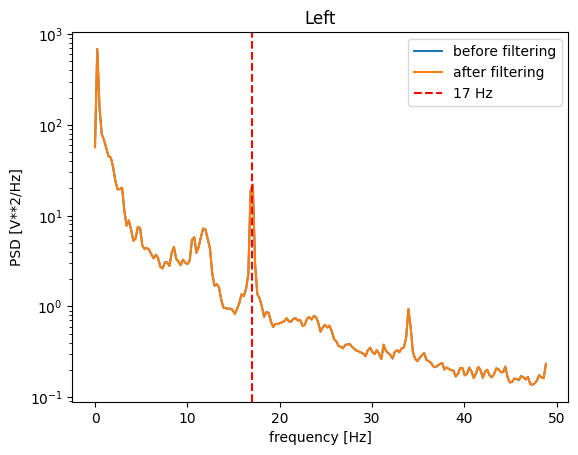

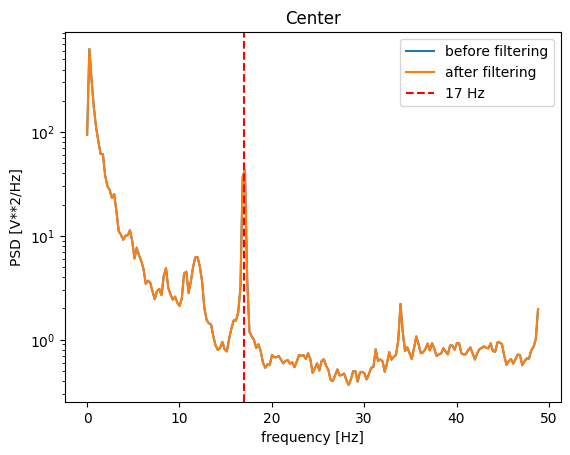

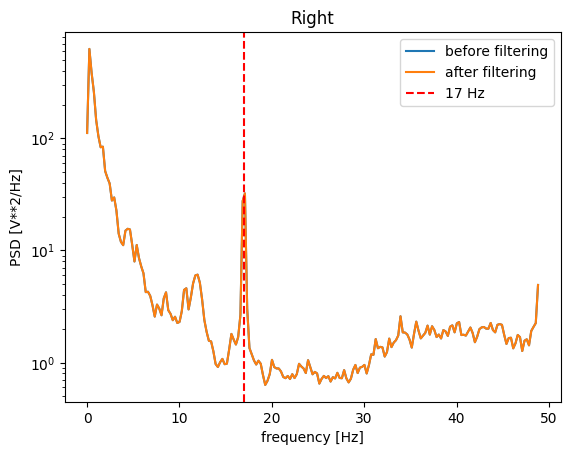

In [167]:
# Compute the PSD for the filtered EEG data
f, Pxx_den_filtered = signal.welch(rls_eeg, fs, nperseg=1024) # f length is 513, Pxx_ded_filtered is 8 rows (channels) x 513 columns (frequencies)
# Keep only the frequencies between 0 and 40 Hz
Pxx_den_filtered = Pxx_den_filtered[:,0:201]

# Find the average PSD for the zone from the channels that are in each zone
left_PSD_filtered = np.mean(Pxx_den_filtered[left_channels_index,:], axis=0)
center_PSD_filtered = np.mean(Pxx_den_filtered[center_channels_index,:], axis=0)
right_PSD_filtered = np.mean(Pxx_den_filtered[right_channels_index,:], axis=0)

# Plot the PSD before and after filtering for zones
for i in range(3):
    plt.figure()
    plt.semilogy(f[0:201], zones[i], label='before filtering')
    plt.semilogy(f[0:201], zones[i], label='after filtering')
    plt.xlabel('frequency [Hz]')
    # Using channel names as labels for the plots
    plt.title(zone_names[i])
    plt.ylabel('PSD [V**2/Hz]')
    # Add a white line at 17 Hz
    plt.axvline(x=17, color='red', linestyle='--', label='17 Hz')
    plt.legend()
    plt.show()
